In [257]:
import autograd.numpy as np
from autograd import grad, elementwise_grad
import autograd.numpy.random as npr
from autograd.misc.optimizers import adam

In [258]:
x0 = 0
x1 = 1

def init_random_params(scale, layer_sizes, rs=npr.RandomState(42)):
    return [(rs.randn(insize, outsize) * scale,   # weight matrix
             rs.randn(outsize) * scale)           # bias vector
            for insize, outsize in zip(layer_sizes[:-1], layer_sizes[1:])]

def tanh(x):
    return (2 / (1.0 + np.exp(-2*x))) - 1

def psi(nnparams, inputs):
    origInput = inputs
    xTilde = (origInput - x0) / (x1 - x0)
    
    for W, b in nnparams:
        outputs = np.dot(inputs, W) + b
        inputs = tanh(outputs)    
        
    return (1-np.exp(xTilde * (1 - xTilde))) * outputs

dpsi = elementwise_grad(psi, 1) # dpsi/dx 
ddpsi = elementwise_grad(dpsi, 1) # d^2psi/dx^2

In [294]:
nnparams = init_random_params(0.1, layer_sizes=[1, 32, 32, 1])
params = {'nn': nnparams, 'E': 3.5}

x = np.linspace(0, 1, 200)[:, None]

def objective(params, step):
    nnparams = params['nn']
    E = params['E']        
    
    wave = psi(nnparams,x)
    zeq = -0.5 * ddpsi(nnparams, x)  - E*wave
    y2 = wave**2
    
    # This is a numerical trapezoid integration
    prob = np.sum((y2[1:] + y2[0:-1]) / 2 * (x[1:] - x[0:-1]))
    
    return np.mean(zeq**2) + (1.0 - prob)**2

def objectiveDebug (params, step) :
    nnparams = params['nn']
    E = params['E']        
    # This is Schrodinger's eqn
    zeq = -0.5 * ddpsi(nnparams, x)  - E*psi(nnparams, x) 
    y2 = psi(nnparams, x)**2
    # This is a numerical trapezoid integration
    prob = np.sum((y2[1:] + y2[0:-1]) / 2 * (x[1:] - x[0:-1]))
    mean = np.mean(zeq**2)
    
    print ("Iteration " + str(step) + " diffeq = " + str(mean) + " prob = " + str(prob))
    print ("loss = " + str(mean + (1-prob)**2) + " E = " + str(params['E']))
    print ("---------------------------------")
    

# This gives us feedback from the optimizer
def callback(params, step, g):
    if step % 100 == 0:
        #print("Iteration {0:3d} objective {1}".format(step,
                                                      #objective(params, step))
        objectiveDebug (params, step)

In [295]:
params = adam(grad(objective), params,
              step_size=0.001, num_iters=5001, callback=callback) 

print(params['E'])

Iteration 0 diffeq = 0.0007965445362353251 prob = 4.475013275716555e-05
loss = 1.0007070462732952 E = 3.5
---------------------------------
Iteration 100 diffeq = 9.955267183789916e-08 prob = 4.746915047307211e-08
loss = 1.000000004614373 E = 3.5282579166462495
---------------------------------
Iteration 200 diffeq = 4.781310450659284e-08 prob = 2.421450592537495e-08
loss = 0.9999999993840931 E = 3.528521596309075
---------------------------------
Iteration 300 diffeq = 4.8332546049341947e-08 prob = 2.4487727271439642e-08
loss = 0.999999999357092 E = 3.528841498347338
---------------------------------
Iteration 400 diffeq = 4.8792565609986736e-08 prob = 2.4734382846710526e-08
loss = 0.9999999993238006 E = 3.5292335656456015
---------------------------------
Iteration 500 diffeq = 4.935232373767873e-08 prob = 2.5034293488625724e-08
loss = 0.9999999992837374 E = 3.5296949905484944
---------------------------------
Iteration 600 diffeq = 5.0021442297777024e-08 prob = 2.539250668834043e-08

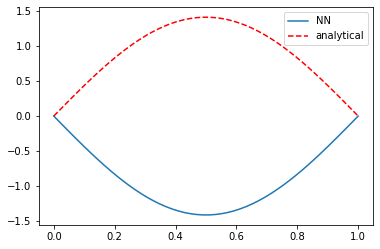

In [297]:
%matplotlib inline
import matplotlib.pyplot as plt

x = np.linspace(0, 1)[:, None]
y = psi(params['nn'], x)

plt.plot(x, y, label='NN')
plt.plot(x, np.sqrt(2) * np.sin(np.pi * x), 'r--', label='analytical')
plt.legend()